In [1]:
import sys  
sys.path.insert(0, '../')

import wandb
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline

import numpy as np
import cupy as cp
import scipy
import model.functions as f
import chainer
import chainer.functions as F
from chainer import serializers
from chainer.backends.cuda import to_cpu, to_gpu

In [3]:
class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

def cos_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def relu(x):
    return x * (x > 0)

def calc_dim(X):
    X = X - cp.mean(X, axis=1).reshape(-1, 1)
    C = X @ X.T
    return cp.trace(C) ** 2 / cp.trace(C @ C)

gpu_id = 0

# Model

In [11]:
name = 'mnist_rc-4_ma_200000_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        config = Bunch(run.config)
        print(run.name, run.id)
        break

# load
from model.cerebellum import Cerebellum
model = Cerebellum(in_size=784, out_size=10, args=config)

for file in os.listdir('../wandb/'):
    if run_id in file:
        model_dir = '../wandb/' + file + '/model.pkl'
        serializers.load_npz(model_dir, model)
        print("load: " + model_dir)
        break
        
model.to_gpu(gpu_id)

# weight
J = model.granule.W.array
idx = model.granule.idx if config.granule == 'rc' else None
mu = model.norm.ma if config.ltd == 'ma' else None
W = model.purkinje.W.array

J.shape, W.shape, (idx.shape if idx is not None else None), (mu.shape if mu is not None else None)

mnist_rc-4_ma_200000_0 3ki8nhpy
load: ../wandb/run-20200603_131624-3ki8nhpy/model.pkl


((200000, 4), (10, 200000), (200000, 4), (1, 200000))

### Calc Z, W

In [271]:
from chainer.datasets import get_mnist

train_data, test_data = get_mnist(withlabel=True, ndim=1)
X, Y = zip(*test_data)

X = cp.array(list(X)).T
Y = cp.array(f.one_hot(Y, 10, dtype=X.dtype)).T
X.shape, Y.shape

((784, 10000), (10, 10000))

In [272]:
Z = model.project(to_gpu(X.T)).array.T
Z.shape

(5970, 10000)

In [273]:
W = Y @ Z.T @ cp.linalg.inv(Z @ Z.T)
W.shape

(10, 5970)

In [274]:
cp.abs(W).sum()

array(2788.0396, dtype=float32)

In [12]:
cp.mean(cp.abs(J).sum(-1))

array(1.5963608, dtype=float32)

### check gradient

In [170]:
from chainer.datasets import get_mnist

train_data, test_data = get_mnist(withlabel=True, ndim=1)
x, label = train_data[0]
x = cp.array(x.reshape(784, 1))

In [171]:
from chainer import Variable
chainer.config.train = False

data = Variable(x.T)
output = model.forward(data, attack=True)
output[0, 4].backward()

grad = data.grad.squeeze()
grad.shape

(784,)

In [311]:
output1 = W @ (relu(J @ x) - mu.reshape(-1, 1))
output1.shape
# cp.sum((output1 - target.reshape(output1.shape))**2)

(10, 1)

In [172]:
if config.granule == 'fc':
    grad2 = J.T @ (cp.expand_dims(W[4], 0).T * ((J @ x) > 0)).squeeze()
# elif config.granule == 'rc':
#     grad2 = cp.zeros(784)
#     grad2 = 2 * J.T @ (((output.array - target) @ W).T * ((J @ x[idx, :]) > 0)).squeeze()
grad2.shape

(784,)

In [59]:
H = ((J * x[:, idx]).sum(-1, keepdims=True) > 0)
H.shape
A = (((output.array - target) @ W).T * H)
A.shape

(1, 200000, 1)

In [173]:
cos_similarity(grad, grad2)

array(0.99999994, dtype=float32)

# Data

In [166]:
env = 'Base'
ENV = {'Base': 'mnist_fc_none_5970_0', 
       'Base + LTD': 'mnist_fc_ma_5970_0',
       'Base + RC': 'mnist_rc-4_none_200000_0',
       'Cerebellum': 'mnist_rc-4_ma_200000_0'}
name = ENV[env]
name = 'mnist_rc-100_none_40000_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        config = Bunch(run.config)
        print(run.name, run.id)
        break

# model
from model.cerebellum import Cerebellum
model = Cerebellum(in_size=784, out_size=10, args=config)

# load
for file in os.listdir('../wandb/'):
    if run_id in file:
        model_dir = '../wandb/' + file + '/model.pkl'
        serializers.load_npz(model_dir, model)
        print("load: " + model_dir)
        break
        
model.to_gpu(gpu_id)

# weight
J = model.granule.W.array
mu = model.norm.ma if model.norm is not None else None
W = model.purkinje.W.array

print("weight shape:", J.shape, W.shape, (mu.shape if mu is not None else None))

mnist_rc-100_none_40000_0 31sjjxfy
load: ../wandb/run-20200603_131223-31sjjxfy/model.pkl
weight shape: (40000, 100) (10, 40000) None


In [167]:
attack = 'fgsm'
attack_name = attack + '-' + name
eps = 0.3
j = 4

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == attack_name:
        run_id = run.id
        config = Bunch(run.config)
        print(run.name, run.id)
        break

# load
for file in os.listdir('../wandb'):
    if run_id in file:
        data = np.load('../wandb' + '/' + file + '/data_' + str(eps) +'.npz', allow_pickle=True)
        print("load data")
        break

# data
X = data['data'].squeeze()
Y = data['output'].squeeze()
X_adv = data['adv_data'].squeeze()
Y_adv = data['adv_output'].squeeze()
grad_info = data['grad_info'].squeeze()
label = data['label'].squeeze()

print("data:", X.shape, Y.shape, X_adv.shape, Y_adv.shape, grad_info.shape, label.shape)
print('acc:', np.sum(Y.argmax(axis=-1) == Y_adv.argmax(axis=-1)))
print('eps:', np.max(np.abs(X - X_adv)))

fgsm-mnist_rc-100_none_40000_0 3p71zm63
load data
data: (10000, 784) (10000, 10) (10000, 784) (10000, 10) (10000, 784) (10000,)
acc: 2056
eps: 0.30000004


### plot pgd

In [41]:
grad = grad_info[:, :, 0]

df = pd.DataFrame()
for i in range(40):
    temp = pd.DataFrame()
    temp['norm'] = grad[:, i]
    temp['step'] = i + 1
    df = df.append(temp)

5.690989179868698


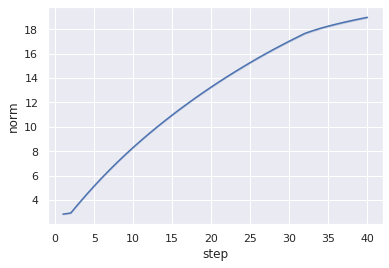

In [43]:
print(np.mean(grad[:, 39]) * eps)
ax = sns.lineplot(x='step', y='norm', ci=95, n_boot=1000, data=df)
# ax.set(title=name, xlabel='Label', ylabel='Output')
# plt.xticks(range(10))
# plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/out_' + name + '.png', dpi=300)

### calc grad 1

In [133]:
K = (J @ to_gpu(X.T) > 0)
grad = J.T @ (cp.expand_dims(W[j], 0).T * K)
print(grad.shape)

K_adv = (J @ to_gpu(X_adv.T) > 0)
grad_adv = J.T @ (cp.expand_dims(W[j], 0).T * K_adv)
print(grad_adv.shape)

print("J", np.max(np.sum(np.abs(J), -1)).item())

(784, 10000)
(784, 10000)
J 24.711246490478516


In [10]:
H = relu(J @ to_gpu(X.T))
Z = H - mu.reshape(-1, 1) if mu is not None else H
Z.shape

(2000, 10000)

In [114]:
Z.mean(-1)

array([0.08931024, 0.05083937, 0.04227418, ..., 0.19299784, 0.11534549,
       0.00137857], dtype=float32)

In [109]:
mu.squeeze()

array([0.08558659, 0.05262279, 0.04440761, ..., 0.18534889, 0.10427296,
       0.00382837])

In [99]:
A = Z @ Z.T

In [100]:
cp.max(cp.abs(A).sum(0))

array(699934.4248727)

### calc grad 2

In [168]:
from tqdm import tqdm
from chainer import Variable
chainer.config.train = False

grad = []
for x in tqdm(X):
    data = Variable(to_gpu(np.expand_dims(x, 0)))
    output = model.forward(data, attack=True)
    output[0, i].backward()
    temp = data.grad.squeeze()
    grad.append(temp)    
grad = cp.array(grad).T
print(grad.shape)

grad_adv = []
for x in tqdm(X_adv):
    data = Variable(to_gpu(np.expand_dims(x, 0)))
    output = model.forward(data, attack=True)
    output[0, i].backward()
    temp = data.grad.squeeze()
    grad_adv.append(temp)
grad_adv = cp.array(grad_adv).T
print(grad_adv.shape)

  0%|          | 10/10000 [00:00<01:49, 90.90it/s]

(784, 10000)


100%|██████████| 10000/10000 [01:58<00:00, 84.70it/s]

(784, 10000)


In [169]:
bound1 = to_cpu(cp.sum(cp.abs(grad), 0) * eps)
bound2 = to_cpu(cp.sum(cp.abs(grad_adv), 0) * eps)
y = Y[:, j]
y_adv = Y_adv[:, j]
delta_y = np.abs(y - y_adv)

print('W_j', np.linalg.norm(W[j], 1))
print('bound', bound1.shape, bound2.shape, y.shape, y_adv.shape)
print('max', bound1.max(), bound2.max(), delta_y.max())
print('mean', bound1.mean(), bound2.mean(), delta_y.mean())

W_j 231.24138
bound (10000,) (10000,) (10000,) (10000,)
max 6.9292054 6.446201 2.3208082
mean 5.6297216 5.423865 0.58285236


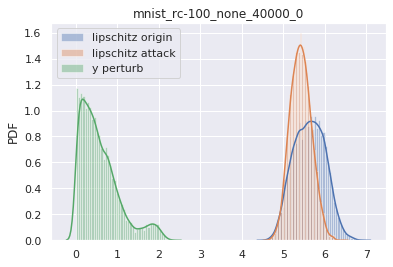

In [170]:
ax = sns.distplot(bound1, label='lipschitz origin')
sns.distplot(bound2, label='lipschitz attack')
sns.distplot(delta_y, label='y perturb')
ax.set(title=name, ylabel='PDF')
plt.legend()
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/lip_' + name + '.png', dpi=300)

In [171]:
j = 4

idx = (label == j)
dist = Y[idx]
dist_adv = Y_adv[idx]

print('dist:', dist.shape, dist_adv.shape)

df = pd.DataFrame()
for i in range(10):
    temp = pd.DataFrame()
    temp['output'] = dist[:, i]
    temp[''] = 'y'
    temp['label'] = i
    df = df.append(temp)
for i in range(10):
    temp = pd.DataFrame()
    temp['output'] = dist_adv[:, i]
    temp[''] = 'y_attack'
    temp['label'] = i
    df = df.append(temp)

dist: (982, 10) (982, 10)


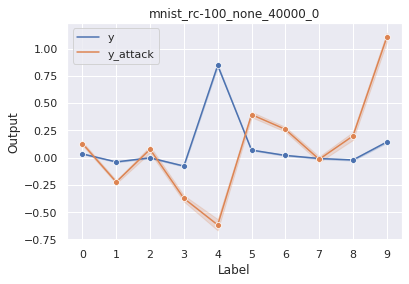

In [172]:
ax = sns.lineplot(x='label', y='output', hue='', marker='o', ci=95, n_boot=1000, data=df)
ax.set(title=name, xlabel='Label', ylabel='Output')
plt.xticks(range(10))
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/out_' + name + '.png', dpi=300)